# Random Forests with PyTorch

What are Random Forests?
Random Forests are an ensemble learning technique that builds multiple decision trees and merges their results to improve accuracy and reduce overfitting.
They are widely used for both classification and regression tasks.

In this script, we'll implement a basic Random Forest classifier using PyTorch (for educational purposes) and apply it to the Iris dataset.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import random
import matplotlib.pyplot as plt

In [23]:
# Load the Iris Dataset
# We'll use the classic Iris dataset for demonstration.
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Simple Decision Tree Implementation

We'll implement a very basic decision tree for demonstration.
In practice, you would use a library like scikit-learn, but here we use PyTorch for educational purposes.

In [24]:
class SimpleDecisionTree:
    def __init__(self, max_depth=3, feature_indices=None):
        self.max_depth = max_depth
        self.feature_indices = feature_indices
        self.tree = None

    def fit(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth:
            self.tree = Counter(y).most_common(1)[0][0]
            return
        best_feat, best_thresh, best_gain = None, None, -1
        for feat in (self.feature_indices if self.feature_indices is not None else range(X.shape[1])):
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                left = y[X[:, feat] <= thresh]
                right = y[X[:, feat] > thresh]
                if len(left) == 0 or len(right) == 0:
                    continue
                gain = self._information_gain(y, left, right)
                if gain > best_gain:
                    best_feat, best_thresh, best_gain = feat, thresh, gain
        if best_gain == -1:
            self.tree = Counter(y).most_common(1)[0][0]
            return
        left_idx = X[:, best_feat] <= best_thresh
        right_idx = X[:, best_feat] > best_thresh
        self.tree = {
            'feat': best_feat,
            'thresh': best_thresh,
            'left': SimpleDecisionTree(self.max_depth, self.feature_indices),
            'right': SimpleDecisionTree(self.max_depth, self.feature_indices)
        }
        self.tree['left'].fit(X[left_idx], y[left_idx], depth+1)
        self.tree['right'].fit(X[right_idx], y[right_idx], depth+1)

    def _entropy(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def _information_gain(self, y, left, right):
        H = self._entropy(y)
        H_left = self._entropy(left)
        H_right = self._entropy(right)
        return H - (len(left)/len(y))*H_left - (len(right)/len(y))*H_right

    def predict_one(self, x):
        node = self.tree
        while isinstance(node, dict):
            if x[node['feat']] <= node['thresh']:
                node = node['left'].tree
            else:
                node = node['right'].tree
        return node

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

## Random Forest Implementation

In [25]:
class SimpleRandomForest:
    def __init__(self, n_estimators=10, max_depth=3, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.trees = []
        for _ in range(self.n_estimators):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            if self.max_features is None:
                feat_idxs = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
            else:
                feat_idxs = np.random.choice(n_features, self.max_features, replace=False)
            
            tree = SimpleDecisionTree(max_depth=self.max_depth, feature_indices=range(len(feat_idxs)))
            tree.fit(X[idxs][:, feat_idxs], y[idxs])
            self.trees.append((tree, feat_idxs))

    def predict(self, X):
        tree_preds = np.array([tree.predict(X[:, feat_idxs]) for tree, feat_idxs in self.trees])
        tree_preds = tree_preds.T
        y_pred = [Counter(row).most_common(1)[0][0] for row in tree_preds]
        return np.array(y_pred)

## Train and Evaluate the Random Forest

In [26]:
rf = SimpleRandomForest(n_estimators=10, max_depth=3)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Random Forest accuracy on Iris test set: {acc:.2f}')

Random Forest accuracy on Iris test set: 1.00


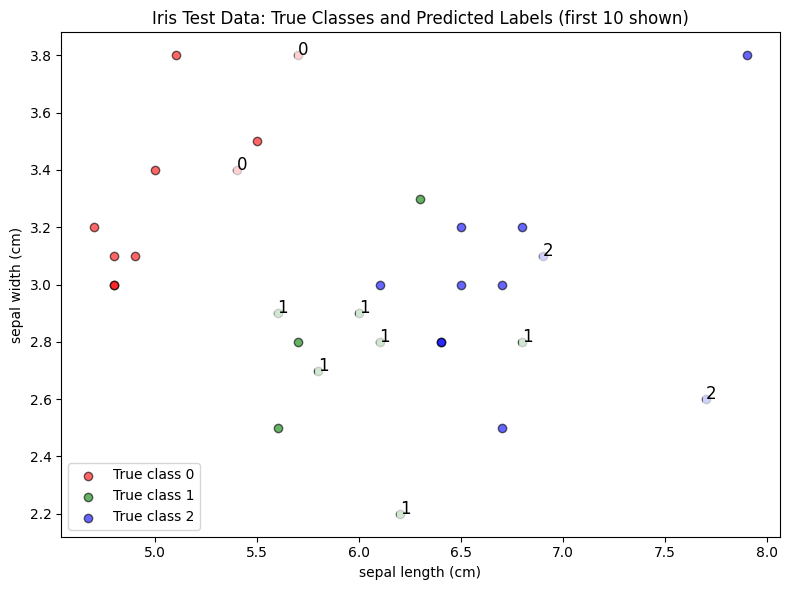

In [27]:
# Show some sample data points and predictions
# We'll plot the first two features and color by predicted class
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    idxs = np.where(y_test == i)[0]
    plt.scatter(X_test[idxs][:, 0], X_test[idxs][:, 1], c=color, label=f"True class {i}", edgecolor='k', alpha=0.6)

# Annotate a few points with their predicted label
for i in range(min(10, len(X_test))):
    plt.text(X_test[i, 0], X_test[i, 1], str(y_pred[i]), fontsize=12, color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Iris Test Data: True Classes and Predicted Labels (first 10 shown)')
plt.legend()
plt.tight_layout()
plt.show() 